# Data Loading

In [4]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

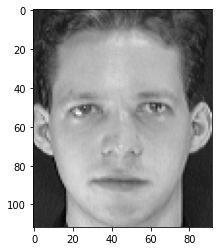

In [5]:
test_image = cv2.imread('archive/s1/1.pgm', -1)
plt.imshow(test_image, cmap='gray')
plt.show()

In [39]:
dataset = []
labels = []
for folder_index in range(1, 40 + 1):
    for file_index in range(1, 10+1):
        file_name = f'archive/s{folder_index}/{file_index}.pgm'
        image = cv2.imread(file_name, -1).astype(np.float32)
        dataset.append(image.reshape(-1))
        labels.append(folder_index)
dataset = np.array(dataset)
labels = np.array(labels).reshape(-1, 1)

In [40]:
def my_train_test_split(X, y):
    trainX = X[::2,  : ]
    testX  = X[1::2, : ]
    trainY = y[::2,  : ]
    testY  = y[1::2, : ]
    return trainX, testX, trainY, testY

trainX, testX, trainY, testY = my_train_test_split(dataset, labels)

In [13]:
class MyPCA:
    def __init__(self, alpha):
        self.alpha = alpha

    def fit(self, X):
        self.U, self.mu = self._implementation(X, self.alpha)
        
    def fit_transform(self, X):
        self.U, self.mu = self._implementation(X, self.alpha)
        centered = X - self.mu
        return centered @ self.U

    def predict(self, X):
        centered = X - self.mu
        return centered @ self.U
        
    def _implementation(self, X, alpha):
        mu = np.mean(X, axis=0)
        Z = X - mu
        cov_mat = Z.T @ Z / Z.shape[0]
        eig_vals, eig_vecs = np.linalg.eigh(cov_mat)

        eig_vals_cumsum = np.cumsum(eig_vals[::-1]) / np.sum(eig_vals)
        rank = np.where(eig_vals_cumsum >= alpha)[0][0] + 1
        return eig_vecs[:, :-(rank + 1):-1], mu

In [14]:
pca = MyPCA(0.85)
pca.fit(trainX)


In [15]:
reduced_train_X = pca.predict(trainX)
reduced_test_X = pca.predict(testX)

# Testing

In [16]:
acc = 0

for i in range(len(testX)):
    norm_array = np.linalg.norm(reduced_train_X - reduced_test_X[i, :], axis=1)
    nearest_neighbour = np.argmin(norm_array)
    acc += trainY[nearest_neighbour] == testY[i]
print(f'accuracy = {acc / len(testX) * 100}%')

accuracy = [95.]%


NameError: name 'v' is not defined

# LDA

In [41]:
def split_data_classes(X, y):
    D = [[] for i in range(40)]
    for i, instance in enumerate(X):
        label_index = y[i][0]-1
        D[label_index].append(instance)
    return D


def calculate_class_means(D):
    mu = []
    for i in range(len(D)):
        mu.append(np.mean(D[i], axis=0))
    return np.array(mu)


def calculate_Sb(D, mu, d, overall_mean): # between class scatter matrix
    Sb = np.zeros((d,d))
    for k in range(len(D)):
        nk = len(D[k])
        temp = np.subtract(mu[k], overall_mean)
        Sb += nk * np.outer(temp, temp)
    return Sb


def calculate_S_total(D, mu, d): # within-class scatter matrix
    S_total  = np.zeros((d,d))
    for i in range(len(D)):
        Z = D[i] - mu[i]
        S_total += Z.T @ Z
    return S_total

In [62]:
class MyLDA:

    def fit(self, X, y):
        self.U = self._implementation(X, y)
        
    def project(self, X):
        return X @ self.U
        
    def _implementation(self, X, y):
        n = X.shape[0]
        d = X.shape[1]
        
        overall_mean = np.mean(X, axis=0)
        
        
        D = split_data_classes(X, y)
        mu = calculate_class_means(D)
        Sb = calculate_Sb(D, mu, d, overall_mean)


        S_total = calculate_S_total(D, mu, d)
        
        _, eig_vecs = np.linalg.eigh(np.linalg.inv(S_total) @ Sb)
        
        # drop first eigen value/vector
        #eig_vals = eig_vals[1:]
        eig_vecs = eig_vecs[:, :-(39 + 1): -1]

        print(S_total[:50, :50])

        return eig_vecs
        
    def _other_implementation(self, X, y):
        labels, counts = np.unique(y, return_counts=True)
        D = []

        for label in labels:
            D.append(X[(y == label).flatten()])
        D = np.array(D)

        class_mu = np.mean(D, axis=1)
        dataset_mu = np.mean(D, axis=(1, 0))
        mu_centered = class_mu - dataset_mu

        Sb = mu_centered.T @ np.diag(counts) @ mu_centered
        Z = D - class_mu[:, None, :]

        S_total = np.einsum('ijk,ijm->km', Z, Z)

        _, eig_vecs = np.linalg.eigh(np.linalg.inv(S_total) @ Sb)

        U = eig_vecs[:, :-(39 + 1): -1]

        print(S_total[:50, :50])

        return U

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.project(X)
            
    def other_fit(self, X, y):
        self.U = self._other_implementation(X, y)
    
    def other_predict(Self, X):
        return X @ Self.U

    def other_fit_transform(self, X, y):
        self.other_fit(X, y)
        return self.other_predict(X)
    

In [63]:
lda = MyLDA()
reduced = lda.fit_transform(trainX, trainY)

[[26788.80066013 26876.20026803 25602.59920871 ... 11827.80001879
   9457.4000107  11317.0001781 ]
 [26876.20026803 29466.79902864 27233.20030904 ... 11513.59974813
   9255.60019016 11125.79980564]
 [25602.59920871 27233.20030904 28123.99973631 ... 11307.00006318
   9819.39967656 10801.40037489]
 ...
 [11827.80001879 11513.59974813 11307.00006318 ... 63593.20050049
  61909.40013504 55786.00011826]
 [ 9457.4000107   9255.60019016  9819.39967656 ... 61909.40013504
  70551.60044861 61242.4000473 ]
 [11317.0001781  11125.79980564 10801.40037489 ... 55786.00011826
  61242.4000473  65632.39996052]]


In [64]:
reduced_other = lda.other_fit_transform(trainX, trainY)

[[26788.795 26876.195 25602.605 ... 11827.801  9457.4   11317.   ]
 [26876.195 29466.799 27233.201 ... 11513.599  9255.6   11125.798]
 [25602.605 27233.201 28124.    ... 11307.004  9819.401 10801.403]
 ...
 [11827.801 11513.599 11307.004 ... 63593.2   61909.41  55785.992]
 [ 9457.4    9255.6    9819.401 ... 61909.41  70551.586 61242.39 ]
 [11317.    11125.798 10801.403 ... 55785.992 61242.39  65632.4  ]]


In [55]:
print(reduced)
print()
print(reduced_other)

[[-9.37025672e+02 -4.89589955e+01  3.34013416e+02 ... -4.41265016e+01
  -1.65978059e+01  3.56007595e+00]
 [-1.37349451e+03 -3.60110704e+02  5.47764773e+02 ... -2.92795641e+00
  -5.78985624e+01  3.32756891e+00]
 [-1.70484303e+03 -4.92386295e+02  6.21389113e+02 ... -4.92059187e+01
  -3.04830441e+01  2.22849835e+01]
 ...
 [-1.68524725e+03  2.65780764e+02  5.63092047e+02 ...  2.78527528e+00
  -1.60338865e+01  6.06780820e-01]
 [-1.57497919e+03  3.50592405e+02  6.01171297e+02 ...  2.18638532e+01
   9.33445370e+00 -6.26255921e+00]
 [-1.59339404e+03  2.03586598e+02  5.75228553e+02 ... -2.53542978e+01
  -5.94240222e+01  4.90945272e+01]]

[[ -882.46702525  -425.94384694    29.55424297 ...     2.78258566
     15.06899659    14.47794732]
 [-1193.72091523  -840.32333705   -74.7297136  ...    22.44637427
     86.81037744    -6.11468412]
 [-1458.20523025 -1085.73443579  -198.87896773 ...    40.18779491
     91.74793914    28.91337014]
 ...
 [-1709.89221917  -606.68126732   201.74608875 ...    26.2181

In [ ]:
reduced_train_X = lda.project(trainX)
reduced_test_X = lda.project(testX)

In [117]:
acc = 0

for i in range(len(testX)):
    norm_array = np.linalg.norm(reduced_train_X - reduced_test_X[i, :], axis=1)
    nearest_neighbour = np.argmin(norm_array)
    acc += trainY[nearest_neighbour] == testY[i]
print(f'accuracy = {acc / len(testX) * 100}%')

accuracy = [94.]%


# KNN

In [91]:
from scipy.stats import mode
class MyKNN:
    def __init__(self, X, y, n_neighbors):
        self.X = X
        self.y = y
        self.n_neighbors = n_neighbors
    
    def predict(self, X_test):
        ans = []

        for datapoint in X_test:
            norms = np.linalg.norm(self.X - datapoint, axis=1)
            indices = np.argpartition(norms, self.n_neighbors)[:self.n_neighbors]
            predictions = self.y[indices]
            ans.append(mode(predictions)[0][0])
        
        return np.array(ans).reshape(-1, 1)

In [107]:
for k in range(1, 9+1, 2):
    clf = MyKNN(trainX, trainY, k)
    predictions = clf.predict(testX)
    print(f'accuracy for KNN with {k} neighbors = {(predictions.flatten() == testY.flatten()).sum() / len(testY) * 100.0}%')

accuracy for KNN with 1 neighbors = 78.0%
accuracy for KNN with 3 neighbors = 67.0%
accuracy for KNN with 5 neighbors = 61.5%
accuracy for KNN with 7 neighbors = 54.0%
accuracy for KNN with 9 neighbors = 51.5%
